In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc

from tqdm import tqdm

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

import keras

plt.style.use('ggplot')

In [26]:
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"","key":""}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sharatsachin/criteo-attribution-modeling

Dataset URL: https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling
License(s): unknown
 99% 633M/641M [00:05<00:00, 87.3MB/s]
100% 641M/641M [00:05<00:00, 113MB/s] 


In [5]:
!unzip -q criteo-attribution-modeling -d ./data

In [6]:
!unzip -q criteo-attribution-modeling

In [7]:
df = pd.read_csv('pcb_dataset_final.tsv', sep='\t', nrows=2_000_000)

In [8]:
df.shape


(2000000, 22)

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              int64  
 1   uid                    int64  
 2   campaign               int64  
 3   conversion             int64  
 4   conversion_timestamp   int64  
 5   conversion_id          int64  
 6   attribution            int64  
 7   click                  int64  
 8   click_pos              int64  
 9   click_nb               int64  
 10  cost                   float64
 11  cpo                    float64
 12  time_since_last_click  int64  
 13  cat1                   int64  
 14  cat2                   int64  
 15  cat3                   int64  
 16  cat4                   int64  
 17  cat5                   int64  
 18  cat6                   int64  
 19  cat7                   int64  
 20  cat8                   int64  
 21  cat9                   int64  
dtypes: float64(2), int

In [11]:
def add_jid(df):
    df['jid'] = df['uid'].map(str) + '_' + df['conversion_id'].map(str)
    return df

df = add_jid(df)

In [12]:
def normalize_time_cols(df):
    min_max_scaler = MinMaxScaler()
    for col in ('timestamp', 'time_since_last_click'):
        col_values = df[col].to_numpy().reshape(-1, 1)
        df[col + '_norm'] = min_max_scaler.fit_transform(col_values)
    return df

df = normalize_time_cols(df)

In [13]:
n_campaigns = len(df['campaign'].unique())

def sample_campaigns(df, n_campaigns):
    campaigns = np.random.choice(df['campaign'].unique(), n_campaigns, replace=False)
    return df[ df['campaign'].isin(campaigns) ]

df = sample_campaigns(df, n_campaigns)

In [14]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name='count')
        return df[ df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].to_numpy() ) ]

df = filter_journeys_by_length(df, min_touchpoints=2)

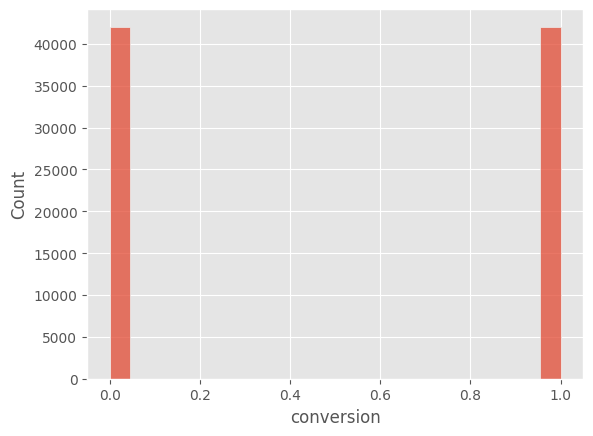

In [15]:
## balance the convert and no convert
def balance_conversions(df):
    df_converted = df[df['conversion'] == 1]
    df_not_converted = df[df['conversion'] == 0]

    number_of_splits = 100 * df_not_converted.shape[0] / df_converted.shape[0]
    df_not_converted_jids = np.array_split(df_not_converted['jid'].unique(), number_of_splits)

    df_not_converted_sampled = df_not_converted.iloc[0:0]
    for jid_chunk in df_not_converted_jids:
        df_not_converted_chunk = df_not_converted[df_not_converted['jid'].isin(jid_chunk)]
        df_not_converted_sampled = pd.concat([df_not_converted_sampled, df_not_converted_chunk])
        if df_not_converted_sampled.shape[0] > df_converted.shape[0]:
            break

    return pd.concat([df_not_converted_sampled, df_converted]).reset_index(drop=True)

df = balance_conversions(df)
sns.histplot(df["conversion"])
plt.show()

In [16]:
len(df['campaign'].unique())


647

In [17]:
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm
0,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,14584482,29196072,11409686,1973606,22644417,9312274,21091111,24607497_-1,0.000006,0.163527
1,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,10769841,29196072,5824237,138937,1795451,29196072,15351056,28474333_-1,0.000006,0.003426
2,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,31616034,29196072,11409684,26597096,4480345,29196072,29196072,25357769_-1,0.000009,0.000000
3,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,9107790,29196072,32440044,1973606,2687461,29841067,21091108,93907_-1,0.000012,0.101299
4,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,4281154,29196072,28928366,29196072,21857352,29196072,29196072,5588915_-1,0.000022,0.000000


In [18]:
def one_hot_encoder(df, column_names, result_column_name):
    one_hot_indices = {}
    for idx, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            one_hot_indices[str(val) + str(idx)] = len(one_hot_indices)

    def one_hot(values):
        one_hot_rep = np.zeros(len(one_hot_indices))
        for idx, val in enumerate(values):
            one_hot_rep[one_hot_indices[str(val) + str(idx)]] = 1
        return one_hot_rep

    df[result_column_name] = df[column_names].to_numpy().tolist()
    df[result_column_name] = df[result_column_name].map(one_hot)

    return df

df = one_hot_encoder(df, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df = one_hot_encoder(df, ['campaign'], 'campaigns').sort_values(by=['timestamp'])

In [19]:
feature_columns = ['jid', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'cats', 'campaigns', 'conversion']
df = df[feature_columns]

In [20]:
df

,jid,click,cost,time_since_last_click_norm,timestamp_norm,cats,campaigns,conversion
0,24607497_-1,0,0.000010,0.163527,0.000006,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,28474333_-1,0,0.000183,0.003426,0.000006,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,25357769_-1,0,0.000032,0.000000,0.000009,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,93907_-1,1,0.000186,0.101299,0.000012,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,5588915_-1,0,0.000074,0.000000,0.000022,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
84013,4974276_8867151,1,0.000181,0.030606,0.999978,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
84014,6547472_4874491,1,0.001233,0.000171,0.999982,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
84015,11310999_9948445,1,0.001810,0.000026,0.999985,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
29836,12663914_-1,1,0.000054,0.000000,0.999991,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [21]:
gc.collect()


4996

In [22]:
def last_touch_attribution(df):
    # Define a function named last_touch_attribution that takes a DataFrame df as an argument.

    def count_by_campaign(df):
        # Define an inner function count_by_campaign that takes a DataFrame df as an argument.
        counters = np.zeros(n_campaigns)
        # Initialize an array of zeros, counters, with a length of n_campaigns to store the count for each campaign.
        for campaign_one_hot in df['campaigns'].to_numpy():
            # Iterate through the one-hot encoded campaign vectors in the DataFrame df.
            campaign_id = np.argmax(campaign_one_hot)
            # Find the position of the value 1 in the one-hot encoded vector, which corresponds to the campaign ID.
            counters[campaign_id] += 1
            # Increment the count for the corresponding campaign.
        return counters
        # Return the array of campaign counts.

    df_converted = df[df['conversion'] == 1]
    # Filter the DataFrame to include only rows where conversion is 1, storing the result in df_converted.

    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    # Create a boolean index idx by grouping df_converted by 'jid' and finding the rows with the maximum 'timestamp_norm' for each group.

    campaign_impressions = count_by_campaign(df)
    # Call the count_by_campaign function to count the number of impressions for each campaign and store the result in campaign_impressions.

    campaign_conversions = count_by_campaign(df_converted[idx])
    # Call the count_by_campaign function to count the number of conversions for each campaign, only considering the last touchpoint, and store the result in campaign_conversions.

    conversion_ratio = campaign_conversions / (campaign_impressions + 1)
    # Calculate the conversion ratio for each campaign (conversions / (impressions + 1)) and store the result in conversion_ratio. Adding 1 to avoid division by zero.

    conversion_ratio /= conversion_ratio.sum()
    # Normalize the conversion ratios so that their sum equals 1.

    return conversion_ratio
    # Return the normalized conversion ratios for each campaign.

lta = last_touch_attribution(df)
# Call the last_touch_attribution function to calculate the normalized conversion ratios for each campaign and assign the result to lta.

gc.collect()
# Call the garbage collector to free up unused memory.


0

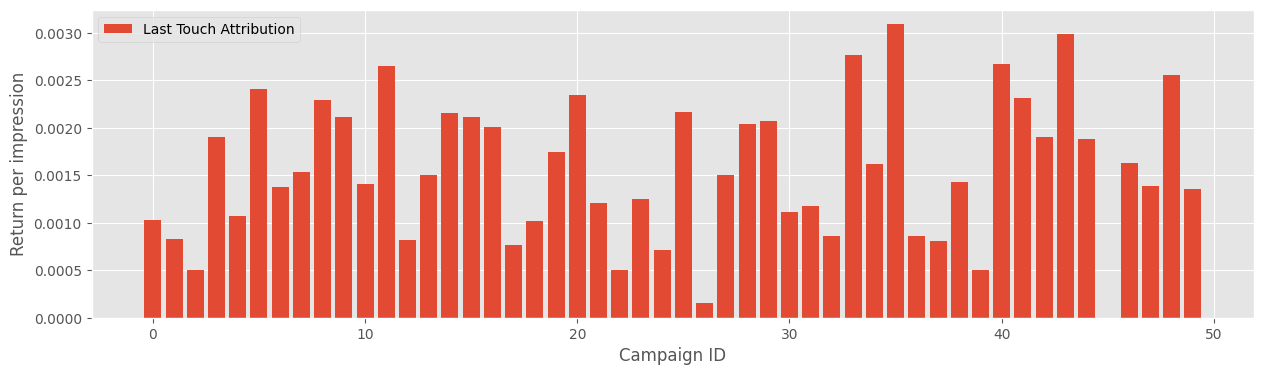

In [23]:
campaign_idx = range(150,200)

x = range(len(lta[campaign_idx]))
y = lta[campaign_idx]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(x, y, label='Last Touch Attribution')
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [24]:
df = df.sort_values(by='jid')
gc.collect()

15

In [25]:
df

,jid,click,cost,time_since_last_click_norm,timestamp_norm,cats,campaigns,conversion
10015,10000148_-1,0,0.000188,0.084952,0.029158,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
10190,10000148_-1,0,0.000010,0.104075,0.181861,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
78897,10001378_24057324,1,0.014663,0.000060,0.896288,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
78864,10001378_24057324,1,0.002365,0.285709,0.895440,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
78874,10001378_24057324,1,0.006895,0.000047,0.895810,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...,...,...,...
52380,9994185_20428302,1,0.000010,0.112783,0.221119,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1
15936,999441_-1,0,0.000010,0.109644,0.920880,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
15586,999441_-1,1,0.000031,0.000000,0.044657,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
25143,999663_-1,0,0.000265,0.246490,0.056854,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


This code defines a function called features for lstm that converts the data frame df into a three-dimensional feature matrix and corresponding labels that fit the LSTM (Long short-term memory) model




In [27]:
def features_for_lstm(df, max_touchpoints):
    # Define a function named features_for_lstm that takes a DataFrame df and an integer max_touchpoints as arguments.

    campaigns_column_names = ["campaigns" + str(i) for i in range(df['campaigns'].tolist()[0].shape[0])]
    # Create column names for the campaigns based on the length of the one-hot encoded vectors in the 'campaigns' column.

    campaigns_df = pd.DataFrame(df['campaigns'].tolist(), index= df.index, columns=campaigns_column_names)
    # Convert the list of one-hot encoded vectors in the 'campaigns' column into a DataFrame with individual columns for each campaign.

    print("Number of campaign features = ", len(campaigns_df.columns))
    # Print the number of campaign features.

    cats_column_names = ["cats" + str(i) for i in range(df['cats'].tolist()[0].shape[0])]
    # Create column names for the other categorical features based on the length of the one-hot encoded vectors in the 'cats' column.

    cats_df = pd.DataFrame(df['cats'].tolist(), index= df.index, columns=cats_column_names)
    # Convert the list of one-hot encoded vectors in the 'cats' column into a DataFrame with individual columns for each categorical feature.

    print("Number of other categorical features = ", len(cats_df.columns))
    # Print the number of other categorical features.

    conversion = df["conversion"]
    # Save the 'conversion' column separately.

    df = pd.concat([campaigns_df, cats_df, df.drop(columns=['cats', 'campaigns', 'conversion'])], axis=1)
    # Concatenate the campaign and categorical feature DataFrames with the original DataFrame, excluding the 'cats', 'campaigns', and 'conversion' columns.

    del campaigns_df
    del cats_df
    gc.collect()
    # Delete intermediate DataFrames and call the garbage collector to free up memory.

    data_2d = df.drop(columns=["jid"]).to_numpy()
    print(data_2d)
    # Convert the DataFrame to a 2D NumPy array, excluding the 'jid' column.

    split_indices = np.cumsum(np.unique(df["jid"].to_numpy(), return_counts=True)[1])[:-1]
    print(split_indices)
    # Calculate the split indices to divide the data into sequences based on unique 'jid' values.

    data_3d_list = np.split(data_2d, split_indices)
    print(data_3d_list)
    # Split the 2D array into a list of 3D arrays, where each sub-array corresponds to a journey.

    conversion_list = np.split(conversion.to_numpy(), split_indices)
    # Split the 'conversion' data into a list of arrays corresponding to each journey.

    print(conversion_list)

    data_3d = []
    y = []
    for idx, xi in enumerate(data_3d_list):
        # Iterate over each journey in the data_3d_list.

        sorted_indices = xi[:, 3].argsort() # sort by timestamp_norm
        # Sort the journey data by the 'timestamp_norm' column.

        journey_matrix = xi[sorted_indices]
        # Create the sorted journey matrix.

        conversion_xi = conversion_list[idx]
        conversion_xi = conversion_xi[sorted_indices]
        # Sort the conversion data corresponding to the journey.

        padded_journey = []
        padded_conversions = []
        n_touchpoints = xi.shape[0]
        if n_touchpoints >= max_touchpoints:
            # If the number of touchpoints in the journey is greater than or equal to max_touchpoints:
            padded_journey = journey_matrix[:max_touchpoints]
            padded_conversions = conversion_xi[:max_touchpoints]
            # Truncate the journey and conversion data to max_touchpoints.
        else:
            # If the number of touchpoints in the journey is less than max_touchpoints:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints),
                                                     (0, 0)), 'constant', constant_values=(0))
            padded_conversions = np.pad(conversion_xi, ((0, max_touchpoints - n_touchpoints)),
                                        'constant', constant_values=(0))
            # Pad the journey and conversion data to max_touchpoints with zeros.

        data_3d.append(padded_journey)
        # Append the padded journey data to the data_3d list.

        y.append(np.max(padded_conversions))
        # Append the maximum conversion value (1 if there is any conversion, otherwise 0) to the y list.

    return np.stack(data_3d), np.array(y)
    # Convert the list of padded journeys to a 3D NumPy array and the list of conversions to a 1D NumPy array, and return them.

x, y = features_for_lstm(df, max_touchpoints=10)
# Call the features_for_lstm function with df and max_touchpoints set to 10, and assign the results to x and y.

print(x.shape, y.shape)
# Print the shapes of the resulting x and y arrays.


Number of campaign features =  647
Number of other categorical features =  1479
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.88014119e-04
  8.49519133e-02 2.91575841e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e-05
  1.04075102e-01 1.81861066e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.46625602e-02
  6.01855567e-05 8.96288166e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.12877797e-05
  0.00000000e+00 4.46567039e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.64864097e-04
  2.46489562e-01 5.68537434e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00652981e-04
  2.53485361e-01 1.12760952e-01]]
[    2     5    11 ... 84009 84013 84015]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[array([0, 0]), array([1, 1, 1]), array([0, 0, 0, 0, 0, 0]), array([0, 0]), array([1, 1, 1]), array([0, 0, 0]), array([0, 0, 0]), array([1, 1]), array([1, 1, 1]), array([0, 0]), array([0, 0, 0]), array([1, 1]), array([0, 0]), array([1, 1]), array([0, 0]), array([0, 0]), array([1, 1]), array([0, 0]), array([1, 1, 1, 1]), array([0, 0]), array([1, 1]), array([0, 0, 0]), array([0, 0, 0]), array([1, 1, 1]), array([0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([0, 0]), array([0, 0, 0, 0, 0]), array([1, 1]), array([1, 1, 1]), array([1, 1]), array([0, 0]), array([0, 0, 0]), array([1, 1]), array([1, 1, 1, 1]), array([1, 1]), array([0, 0]), array([0, 0, 0, 0, 0]), array([1, 1]), array([1, 1]), array([0, 0]), array([1, 1, 1]), array([0, 0, 0]), array([1, 1, 1, 1, 1, 1]), array([1, 1]), array([0, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1]), array([1, 1]), array([1, 1, 1]), array([1, 1, 1,

In [28]:
del df
gc.collect()

0

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

gc.collect()

0

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras import backend as K
import keras.utils
import gc

keras.utils.set_random_seed(38)
# Import necessary libraries and set the random seed for reproducibility.

n_steps, n_features = x.shape[1], x.shape[2]
# Get the number of time steps and features from the input data.

hidden_units = 64
# Set the number of hidden units for the LSTM layer.

main_input = Input(shape=(n_steps, n_features))
# Define the input layer with the shape (n_steps, n_features).

embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)
# Use a Dense layer to map the input to a 128-dimensional embedding space.

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)
# Define the LSTM layer with 64 hidden units, 20% dropout, and return the full sequence of outputs.

attention = Dense(1, activation='tanh')(activations)
# Use a Dense layer with a tanh activation function to compute attention scores.

attention = Flatten()(attention)
# Flatten the attention scores to a 1D array.

attention = Activation('softmax', name='attention_weights')(attention)
# Apply a softmax activation function to get attention weights.

attention = RepeatVector(hidden_units)(attention)
# Repeat the attention weights to match the number of hidden units.

attention = Permute([2, 1])(attention)
# Permute the dimensions of the attention weights for multiplication with LSTM outputs.

weighted_activations = Multiply()([activations, attention])
# Multiply the LSTM outputs by the attention weights to get weighted activations.

weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)
# Use a Lambda layer to sum the weighted activations over the time steps.

main_output = Dense(1, activation='sigmoid')(weighted_activations)
# Define the output layer with a Dense layer and sigmoid activation function for binary classification.

model = Model(inputs=main_input, outputs=main_output)
# Define the model with the specified input and output.

early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3)
# Define an early stopping callback to monitor validation loss and stop training if it doesn't improve for 3 epochs.

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'])
# Compile the model using the rmsprop optimizer, binary cross-entropy loss, and accuracy as a metric.

history = model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1,
                    validation_data=(x_val, y_val), callbacks=[early_stop_callback])
# Train the model using the training data, with a batch size of 64, for up to 50 epochs,
# validating on the validation data, and using the early stopping callback.

score = model.evaluate(x_test, y_test, verbose=0)
# Evaluate the model's performance on the test data.

print('Test score:', score[0])
print('Test accuracy:', score[1])
# Print the test loss and test accuracy.

gc.collect()
# Call the garbage collector to free up unused memory.


Epoch 1/50
272/272 [==============================] - 14s 35ms/step - loss: 0.2227 - accuracy: 0.9127 - val_loss: 0.1683 - val_accuracy: 0.9345
Epoch 2/50
272/272 [==============================] - 7s 26ms/step - loss: 0.1461 - accuracy: 0.9426 - val_loss: 0.1550 - val_accuracy: 0.9395
Epoch 3/50
272/272 [==============================] - 10s 35ms/step - loss: 0.1273 - accuracy: 0.9516 - val_loss: 0.1572 - val_accuracy: 0.9391
Epoch 4/50
272/272 [==============================] - 8s 30ms/step - loss: 0.1160 - accuracy: 0.9551 - val_loss: 0.1376 - val_accuracy: 0.9485
Epoch 5/50
272/272 [==============================] - 9s 33ms/step - loss: 0.1033 - accuracy: 0.9587 - val_loss: 0.1413 - val_accuracy: 0.9483
Epoch 6/50
272/272 [==============================] - 7s 25ms/step - loss: 0.0963 - accuracy: 0.9642 - val_loss: 0.1287 - val_accuracy: 0.9531
Epoch 7/50
272/272 [==============================] - 8s 31ms/step - loss: 0.0905 - accuracy: 0.9658 - val_loss: 0.1191 - val_accuracy: 0.95

3952

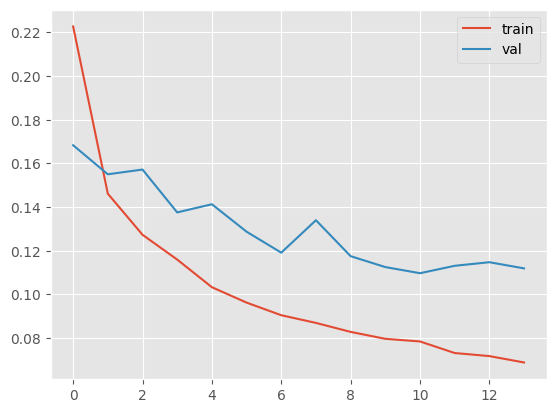

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [32]:
def get_campaign_id(journey_step):
    return np.argmax(journey_step[0:n_campaigns])
# Define a function get_campaign_id that takes a journey_step as input and returns the index of the maximum value
# in the one-hot encoded vector, representing the campaign ID.

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weights').output)
# Create a new model attention_model that takes the same input as the original model but outputs the attention weights layer.

all_attribution_weights = attention_model.predict(x_train)
# Use the attention_model to predict the attention weights for the training data x_train.

print("Number of max touchpoints in a journey = ", all_attribution_weights[0].shape[0])
# Print the maximum number of touchpoints in a journey, based on the shape of the attention weights of the first sample.

attributions = np.zeros(n_campaigns)
# Initialize an array attributions with zeros, to store the attribution values for each campaign.

campaign_freq = np.zeros(n_campaigns)
# Initialize an array campaign_freq with zeros, to store the frequency of each campaign.

for i, attribution_weights in enumerate(all_attribution_weights):
    # Loop through each sample's attention weights.
    for campaign, attribution_weight in enumerate(attribution_weights):
        # Loop through each touchpoint's attention weight in the sample.
        if np.sum(x_train[i][campaign]) > 0:
            # Check if the touchpoint exists in the current sample (i.e., check if any feature value is greater than 0).
            campaign_id = get_campaign_id(x_train[i][campaign])
            # Get the campaign ID for the current touchpoint.
            attributions[campaign_id] += attribution_weight
            # Add the current touchpoint's attention weight to the corresponding campaign's attribution value.
            campaign_freq[campaign_id] += 1
            # Increment the frequency count for the current campaign.

attention_attribution = attributions / (campaign_freq + 1)
# Calculate the attribution for each campaign by dividing the total attention weights by the frequency count plus one.

attention_attribution /= attention_attribution.sum()
# Normalize the attributions so that their sum equals 1.

print("Attribution for # of campaigns = ", attention_attribution.shape[0])
# Print the number of campaigns for which attribution values are calculated.


544/544 [==============================] - 3s 5ms/step
Number of max touchpoints in a journey =  10
Attribution for # of campaigns =  670


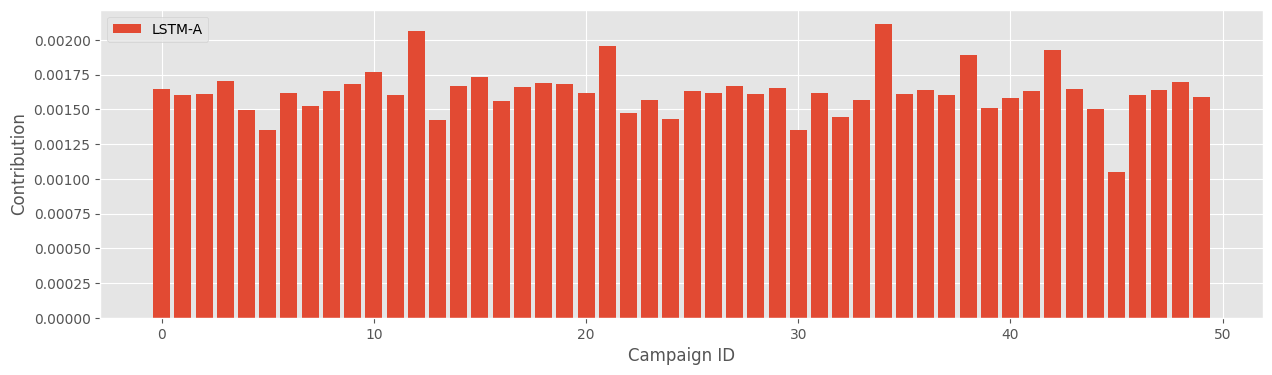

In [33]:
plt_x = range(len(attention_attribution[campaign_idx]))
plt_y = attention_attribution[campaign_idx]

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(plt_x, plt_y, label='LSTM-A')
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

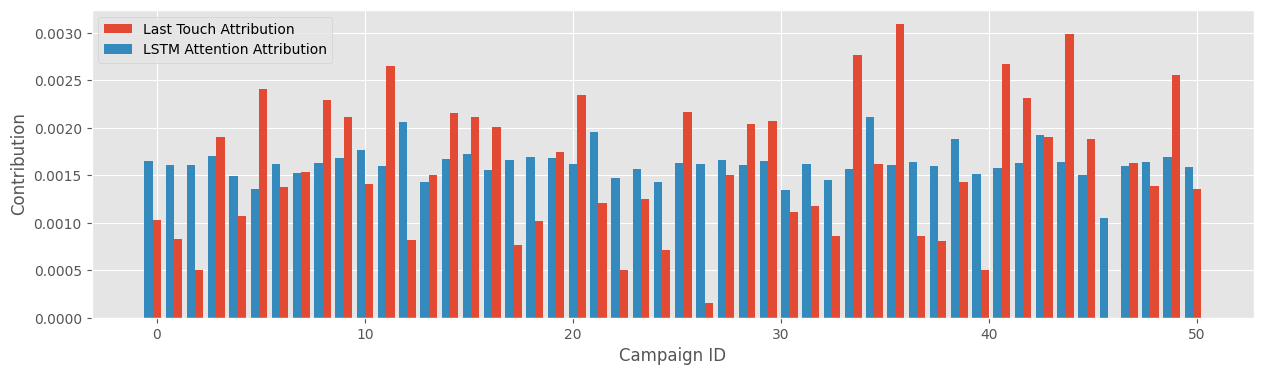

In [34]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)

bar_width = 0.4

plt_lta_x = np.linspace(0, len(campaign_idx), len(campaign_idx))
plt_att_x = np.linspace(0, len(campaign_idx), len(campaign_idx)) - bar_width

plt.bar(plt_lta_x, lta[campaign_idx], width=bar_width, label='Last Touch Attribution')
plt.bar(plt_att_x, attention_attribution[campaign_idx], width=bar_width, label='LSTM Attention Attribution')
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()